In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('EasyVisa.csv')

In [3]:
data.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


## Null values

```
There are no null values
```

In [5]:
data.isnull().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

### creating company age column

In [25]:
from datetime import datetime

today_year = datetime.today().year
data['company_age'] = today_year - data['yr_of_estab']

In [26]:
data.drop(columns='yr_of_estab', inplace=True)
data['company_age']

0         17
1         22
2         16
3        127
4         19
        ... 
25475     16
25476     18
25477    114
25478    137
25479     64
Name: company_age, Length: 25480, dtype: int64

### TYpes of features


In [27]:
num_features = [feature for feature in data.columns if data[feature].dtype != 'O']
num_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [28]:
cat_features = [feature for feature in data.columns if data[feature].dtype == 'O'][1:]
cat_features

['continent',
 'education_of_employee',
 'has_job_experience',
 'requires_job_training',
 'region_of_employment',
 'unit_of_wage',
 'full_time_position',
 'case_status']

#### `discrete features` & `continous features`

In [29]:
discrete_features = [feature for feature in num_features[:-1] if data[feature].nunique() <=25]
continous_features = [feature for feature in num_features[:-1] if data[feature].nunique() >=25]
print(discrete_features)
print(continous_features)

[]
['no_of_employees', 'prevailing_wage']


### `splitting into X & y`

In [30]:
X = data.drop('case_status', axis=1)
y = data['case_status']

In [31]:
y = np.where(y=='Denied', 1, 0)

In [32]:
num_features

['no_of_employees', 'prevailing_wage', 'company_age']

### HAndling skewness & kurtosis

```
no of employees column is highly skewed with value as 206
company_age is also skewed
prevailing wage is under control
```
```
ao we will perform power transofrmation (named yeo-johnson method which works on both positive and negative vaues includign zero, boxcox tranformation can only handle positive values) on above two columns to reduce skewness
we will not take prevailng_wage as it is somewaht normally distributed
```

In [46]:
data[num_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

```
kurtossis value is also high for no_of_employees and company_age col
```

In [47]:
data[num_features].kurtosis(axis=0, skipna=True)

no_of_employees    206.335020
prevailing_wage      0.824274
company_age          3.506957
dtype: float64

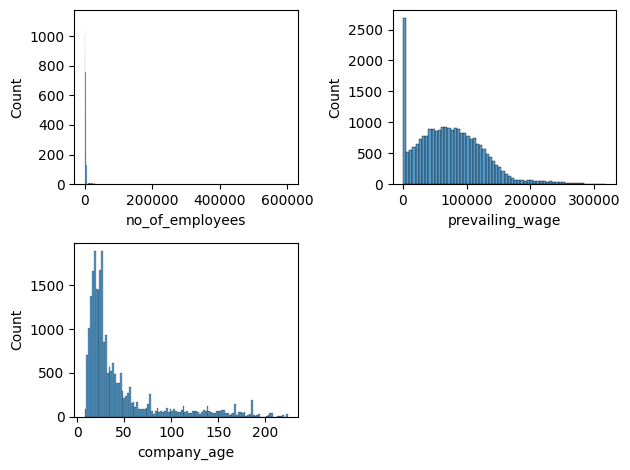

In [33]:
# num_features.remove('yr_of_estab')
for i, col in enumerate(num_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(data[col])
    plt.xlabel(col)
    plt.tight_layout()

In [34]:
X[continous_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
dtype: float64

```
transforming the columns and reducing kurtosis
```

In [35]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transformer_features = ['no_of_employees',  'company_age']
X_copy = pt.fit_transform(X[transformer_features])

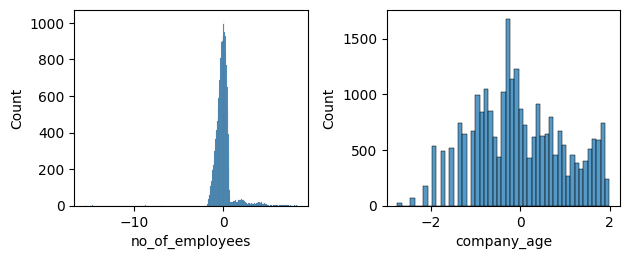

In [39]:
X_copy = pd.DataFrame(X_copy, columns=transformer_features)
for i, col in enumerate(transformer_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(X_copy[col])
    plt.xlabel(col)
    plt.tight_layout()

#### columns after applying transformation

In [41]:
X_copy.skew(axis=0, skipna=True)


no_of_employees    0.399339
company_age        0.103264
dtype: float64

In [42]:
X_copy.kurtosis(axis=0, skipna=True)

no_of_employees    35.701547
company_age        -0.652146
dtype: float64

In [54]:
from sklearn.preprocessing import PowerTransformer
new = PowerTransformer(method='yeo-johnson')
transformer_features = ['no_of_employees']
nenew = new.fit_transform(X[transformer_features])
nenew = pd.DataFrame(nenew, columns=transformer_features)
nenew.kurtosis(axis=0)

no_of_employees    35.701547
dtype: float64

<Axes: xlabel='no_of_employees', ylabel='Count'>

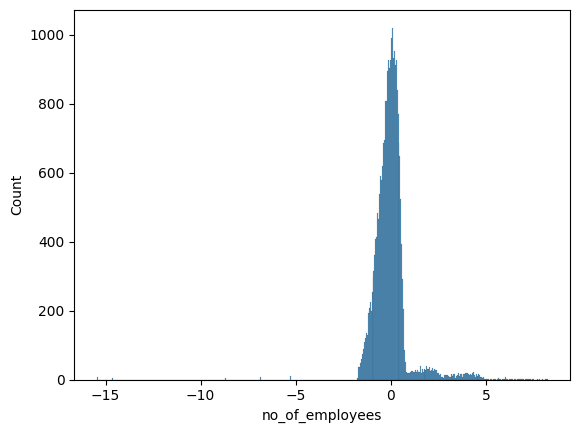

In [51]:
sns.histplot(nenew['no_of_employees'])

```PIPELINE AND COLUMN TRANSFORMER```

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [53]:
from scipy.stats import kurtosis
kurtosis(nenew)

array([35.69430654])

In [55]:
data.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'region_of_employment',
       'prevailing_wage', 'unit_of_wage', 'full_time_position', 'case_status',
       'company_age'],
      dtype='object')

In [56]:
data['full_time_position'].nunique()

2

In [74]:
ordinal_columns = [feature for feature in X.columns if X[feature].nunique()==2]
one_hot_encoder_columns = [feature for feature in data.columns if data[feature].nunique()>2 and data[feature].nunique()<20]
transformer_columns = transformer_features

In [75]:
print(f'ordinal_columns: {ordinal_columns}')
print(f'one_hot_encoder_columns: {one_hot_encoder_columns}' )
print(f'transformer_columns: {['no_of_employees', 'company_age']}')

ordinal_columns: ['has_job_experience', 'requires_job_training', 'full_time_position']
one_hot_encoder_columns: ['continent', 'education_of_employee', 'region_of_employment', 'unit_of_wage']
transformer_columns: ['no_of_employees', 'company_age']


['no_of_employees']

In [67]:
num_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

numeric_transformer = StandardScaler()
oh_encoder = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transformer_pipeline = Pipeline(steps=[('transformer', PowerTransformer(method='yeo-johnson'))])

preprocessor = ColumnTransformer(
                [
                    ('onehotencoder', oh_encoder, one_hot_encoder_columns),
                    ('ordinal_encoder', ordinal_encoder, ordinal_columns),
                    ('transformer', transformer_pipeline, transformer_columns),
                    ('standard_scaler', numeric_transformer, num_features)
                ]
            )

In [77]:
X = preprocessor.fit_transform(X)

In [78]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

## IMbalance data set 
### Technique to hadle imbalance
    1) down sampling of majority
    2) over sampling of minority
    3) over sampling using smote - oversampling by creating synthetic samples using KNN 
    4) enesmble method (if there are 3:1 ratio then take three models 1:1, 1:1, 1:1)
    5) Focal loss - penalise majority samples during loss calculation and give more weight to minority class  samples
smote technique


In [81]:
data['case_status'].value_counts()

case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

In [93]:
pd.value_counts(y)

0    17018
1     8462
Name: count, dtype: int64

In [97]:
from imblearn.combine import SMOTEENN, SMOTETomek

smt = SMOTEENN(random_state=42, sampling_strategy='minority') 
X_new, y_new = smt.fit_resample(X, y)
print(X_new.shape, y_new.shape)
pd.value_counts(y_new)  

(17180, 26) (17180,)


1    9267
0    7913
Name: count, dtype: int64

## Train test split

In [87]:
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# smt = SMOTEENN(random_state=42, sampling_strategy='minority')
# lg = LogisticRegression()
# X_res, y_res = smt.fit_resample(X, y)

# X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
# lg.fit(X_train, y_train)
# y_pred = lg.predict(X_test)
# print(classification_report(y_test, y_pred=y_pred))
# print(confusion_matrix(y_test, y_pred))

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42, stratify=y_new)


In [99]:
X_train.shape, X_test.shape

((13744, 26), (3436, 26))

In [108]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# from catboost import 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, roc_curve


### defining model score fucntion

In [119]:
def evaluate_model_scores(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return acc, f1, precision, recall, roc_auc

### creating dictionnary for models

In [116]:
models = {
    'logistic regression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC(),
    'XGBClassifier': XGBClassifier()

}

### model fitting and returning model performance as dataframe

In [122]:
def evaluate_model(X, y, models: dict):
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42, stratify=y_new)
    
    models_list = []
    accuracy_list = []
    auc = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        model_train_accuracy, model_train_f1_score, model_train_precision,\
        model_train_recall, model_train_roc_auc = evaluate_model_scores(y_train, y_train_pred)

        model_test_accuracy, model_test_f1_score, model_test_precision,\
        model_test_recall, model_test_roc_auc = evaluate_model_scores(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1_score)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_roc_auc))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1_score))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_roc_auc))
        auc.append(model_test_roc_auc)
        print('='*35)
        print('\n')

    report = pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['model', 'accuracy_score']).sort_values(by=['accuracy_score'], ascending=False)

    return report   


In [123]:
model_report = evaluate_model(X=X_new, y=y_new, models=models)

logistic regression
Model performance for Training set
- Accuracy: 0.8587
- F1 score: 0.8667
- Precision: 0.8827
- Recall: 0.8512
- Roc Auc Score: 0.8593
----------------------------------
Model performance for Test set
- Accuracy: 0.8530
- F1 score: 0.8615
- Precision: 0.8757
- Recall: 0.8478
- Roc Auc Score: 0.8535


KNeighborsClassifier
Model performance for Training set
- Accuracy: 0.9686
- F1 score: 0.9712
- Precision: 0.9613
- Recall: 0.9814
- Roc Auc Score: 0.9675
----------------------------------
Model performance for Test set
- Accuracy: 0.9331
- F1 score: 0.9391
- Precision: 0.9216
- Recall: 0.9574
- Roc Auc Score: 0.9310


DecisionTreeClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9162
- F1 score: 0.9226
- Precision: 0.9187
- Recall: 0.9266
- Roc Auc Score: 0.9153


RandomForestClassifier
Model perf

In [124]:
model_report

,model,accuracy_score
3,RandomForestClassifier,0.945576
1,KNeighborsClassifier,0.933062
7,XGBClassifier,0.927241
2,DecisionTreeClassifier,0.916182
5,GradientBoostingClassifier,0.885914
6,SVC,0.883877
4,AdaBoostClassifier,0.858556
0,logistic regression,0.853027


### settting up the params

In [129]:
# set params

xgboost_params = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1,6, 2)
}

rf_params = {
    'max_depth': [10, 12, None, 15, 20],
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [10, 50, 100, 200]
}

knn_params = {
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 4, 5, 6, 7, 9]
}

### setting up dict for gridsearchcv or randomized search cv


In [130]:
grid_search_models = [
    ('xgboost', XGBClassifier(), xgboost_params),
    ('random_forest', RandomForestClassifier(), rf_params),
    ('KNN', KNeighborsClassifier(), knn_params)
]

### hyperparameter tuning

In [133]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model_param = {}

for name, model, params in grid_search_models:
    grid = RandomizedSearchCV(estimator=model,
                        param_distributions=params,
                        cv=3, 
                        verbose=2,
                        n_iter=100,
                        n_jobs=1)
    grid.fit(X_new, y_new)
    model_param[name] = grid.best_params_

for model_name in model_param:
    print(f'best params for {model_name}')
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.0s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=5, min_ch

In [134]:
best_models = {
    'xgboost': XGBClassifier(**model_param['xgboost']),
    'random_forest': RandomForestClassifier(**model_param['random_forest']),
    'KNN': KNeighborsClassifier(**model_param['KNN'], n_jobs=-1), 
}
tuned_report = evaluate_model(X=X_new, y=y_new, models=best_models)

xgboost
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9991
- Precision: 0.9984
- Recall: 0.9997
- Roc Auc Score: 0.9989
----------------------------------
Model performance for Test set
- Accuracy: 0.9395
- F1 score: 0.9440
- Precision: 0.9424
- Recall: 0.9455
- Roc Auc Score: 0.9390


random_forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9441
- F1 score: 0.9483
- Precision: 0.9458
- Recall: 0.9509
- Roc Auc Score: 0.9435


KNN
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9642
- F1 score: 0.9673
- Precision: 0.9534
- Recall: 0.9817
- Roc Auc Score: 0.9627




In [135]:
tuned_report

,model,accuracy_score
2,KNN,0.964203
1,random_forest,0.944121
0,xgboost,0.939464


### KNN turns out to best model for our data

In [136]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9642
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1583
           1       0.95      0.98      0.97      1853

    accuracy                           0.96      3436
   macro avg       0.97      0.96      0.96      3436
weighted avg       0.96      0.96      0.96      3436



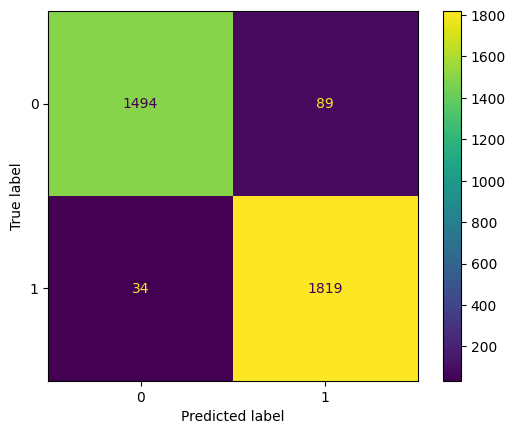

In [137]:

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [138]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)